In [ ]:
# throws an error if your Drive folder doesn't contain everything needed
from google.colab import drive
drive.mount('/content/drive/')

!ls "/content/drive/My Drive/Comp551/Assignment 1"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
a1_final.ipynb	dataset  README.md  requirements.txt  writeup.pdf


**Subtask1:**
Load the datasets into NumPy or Pandas objects in Python.



In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

data_path = "/content/drive/My Drive/Comp551/Assignment 1/dataset/"

parkinsons_data = pd.read_csv(data_path + "parkinsons_updrs.data")
parkinsons_names = open(data_path + "parkinsons_updrs.names").read()

wdbc_data = pd.read_csv(data_path + "wdbc.data")
wdbc_names = open(data_path + "wdbc.names").read()

print('Parkinsons Shape:', parkinsons_data.shape)
print('Breast Cancer Shape:', wdbc_data.shape)

Parkinsons Shape: (5875, 22)
Breast Cancer Shape: (568, 32)


1. noticed that .name files only contain dataset description
2. wdbc.data does not have column names, we shall find them in Attribute information section in wdbc.name

**Subtask2:** Clean the data.

**Parkinson:**

In [ ]:
# Function for testing inter-correlation
def drop_by_corr(df, thresh):
    feats = [c for c in df.select_dtypes(include=[np.number]).columns
             if c != 'motor_UPDRS']
    corr = df[feats].corr().abs()
    r_target = df[feats].corrwith(df['motor_UPDRS']).abs() if 'motor_UPDRS' in df.columns else pd.Series(0, index=feats)

    to_drop = set()
    for i, c1 in enumerate(feats):
        if c1 in to_drop: continue
        for c2 in feats[i+1:]:
            if c2 in to_drop: continue
            if corr.loc[c1, c2] >= thresh:
                  drop = c1 if r_target.get(c1,0) < r_target.get(c2,0) else c2
                  to_drop.add(drop)

    return sorted(to_drop)
dropped = drop_by_corr(parkinsons_data, thresh=0.95)
#parkinsons_data = parkinsons_data.drop(columns=dropped) # dropping doesn't effect the result much
print("Highly Intercorrelated Features", dropped)

Highly Intercorrelated Features ['Jitter:DDP', 'Jitter:PPQ5', 'Jitter:RAP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:DDA']


In [ ]:
def clean_parkinson(df):
  if df.isna().sum().sum() != 0:
    df = df.replace('?', np.nan).dropna(axis=0).copy()
  for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
  df = df.drop(columns=['subject#'])
  df = df.drop_duplicates().reset_index(drop=True)
  target_col = 'motor_UPDRS'
  feature_cols = [c for c in df.columns if c != target_col]
  scaler = StandardScaler()
  X_scaled = pd.DataFrame(
        scaler.fit_transform(df[feature_cols]),
        columns=feature_cols,
        index=df.index
        )
  return pd.concat([X_scaled, df[[target_col]]], axis=1)

parkinsons_data = clean_parkinson(parkinsons_data)
print('Shape:', parkinsons_data.shape)
parkinsons_data.head()


Shape: (5875, 21)


,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,...,Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS
0,0.815695,-0.682509,-1.632090,0.502745,0.082905,-0.284242,0.327453,-0.028637,0.328505,-0.324594,...,-0.209709,-0.423356,-0.543466,-0.209704,-0.298721,-0.009205,-1.214066,-1.478500,-0.650658,28.199
1,0.815695,-0.682509,-1.500676,0.549103,-0.560793,-0.756723,-0.533746,-0.476212,-0.534825,-0.534016,...,-0.545158,-0.565592,-0.529955,-0.545153,-0.351965,1.282650,-1.055119,-1.247880,-1.218585,28.447
2,0.815695,-0.682509,-1.369410,0.595367,-0.238944,-0.539382,-0.300038,-0.320767,-0.298983,-0.669115,...,-0.741592,-0.702426,-0.645545,-0.741587,-0.199370,0.318711,-0.784860,-1.540139,-0.103280,28.695
3,0.815695,-0.682509,-1.257773,0.634716,-0.155370,-0.485186,-0.344859,-0.170682,-0.344871,-0.423692,...,-0.460540,-0.449763,-0.392849,-0.460787,-0.071754,0.644530,-0.536487,-1.062115,1.237075,28.905
4,0.815695,-0.682509,-1.108169,0.687522,-0.498557,-0.663894,-0.658604,-0.529814,-0.659682,-0.658276,...,-0.783145,-0.651413,-0.464905,-0.783392,-0.343370,1.036305,-0.689195,-1.297953,-0.283954,29.187


After preprocesing Parkinson Dataset, We have found:
1. No missing values
2. No need for Categorical encoding as sex is (0 or 1)
3. No duplicate rows
4. Standardizing features other than our target
5. From correlation analysis, we found "total_UPDRS" columns has really high correlation with the target feature, but we kept it according to ED post
6. We have found highly inter-correlated features, but discovered dropping them doesn't change the performance.

**Wdbc:**

In [ ]:
wdbc_columns = [
    "ID", "Diagnosis",
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
    "compactness_se", "concavity_se", "concave_points_se", "symmetry_se", "fractal_dimension_se",
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
    "compactness_worst", "concavity_worst", "concave_points_worst", "symmetry_worst", "fractal_dimension_worst"
]
wdbc_data = pd.read_csv(data_path + "wdbc.data", header=None, names=wdbc_columns)
print(wdbc_data.head())
print('Shape:', wdbc_data.shape)


         ID Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [ ]:
dropped = drop_by_corr(wdbc_data, thresh=0.95)
#wdbc_data = wdbc_data.drop(columns=dropped)
print("Highly Intercorrelated Features", dropped)

Highly Intercorrelated Features ['area_mean', 'area_se', 'perimeter_mean', 'perimeter_se', 'perimeter_worst', 'radius_worst']


In [ ]:
def clean_wdbc(df):
  if df.isna().sum().sum() != 0 or (df.eq('?').any().any()):
    df = df.replace('?', np.nan).dropna(axis=0).copy()
  for col in df.columns:
    if col != "Diagnosis":
        df[col] = pd.to_numeric(df[col], errors='coerce')
  df = df.drop(columns=['ID'])
  df = df.drop_duplicates().reset_index(drop=True)
  df["Diagnosis"] = df["Diagnosis"].map({"M": 0, "B": 1})
  features = df.drop(columns=['Diagnosis'])
  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(features)
  df_clean = pd.DataFrame(scaled_features, columns=features.columns)
  df_clean['Diagnosis'] = df['Diagnosis'].values
  return df_clean

wdbc_data = clean_wdbc(wdbc_data)
print('Shape:', wdbc_data.shape)
wdbc_data.head()

Shape: (569, 31)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,0
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,0
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,0
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,0
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,0


After preprocesing Breast Cancer Dataset, we have found and done with:


1.   No missing values
2.   No duplicate rows
3.   Categorical encoding for Diagnosis (M = malignant = 0, B = benign = 1)
4.   Standardizing the 30 numerical features other than Diagnois since the values have a large range of magnitude
5. No features has really strong correlation with target feature
6. For the highly intercorrelated features, removing them does not affect the cross-entropy, so we decided to keep them






**Subtask3:** Compute basic statistics on the data to understand it better.

E.g., what are the distributions of the positive vs. negative classes, what are the distributions of some of the numerical features?


**Parkinson:**

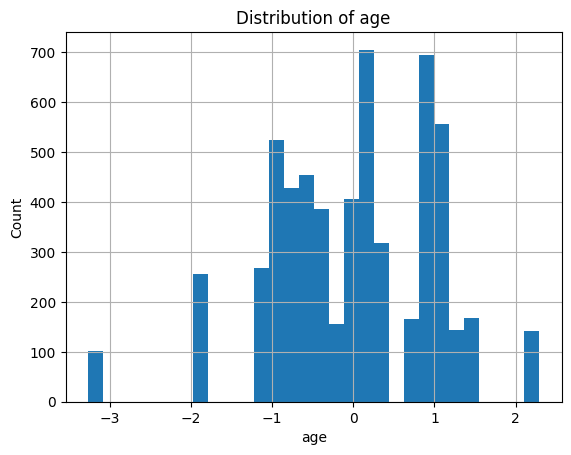

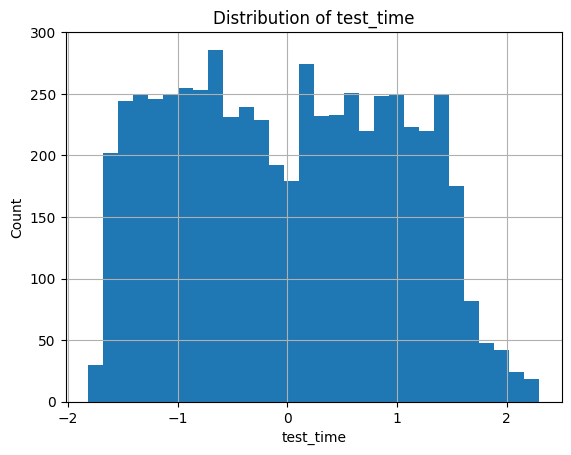

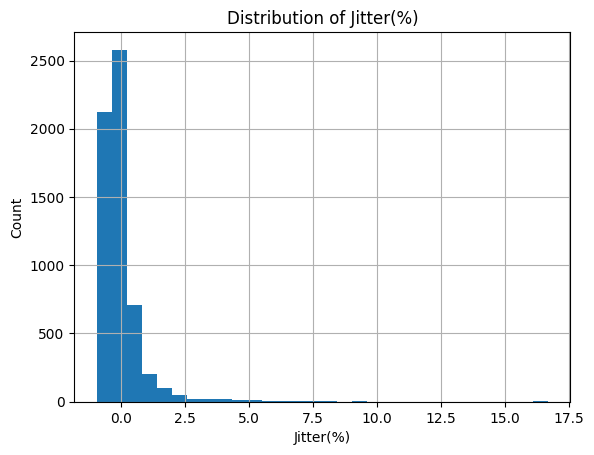

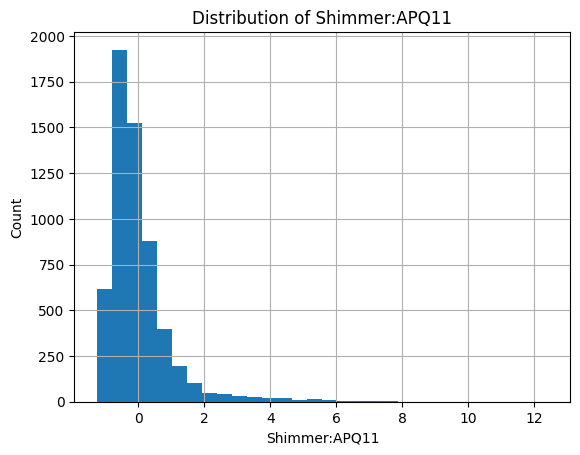

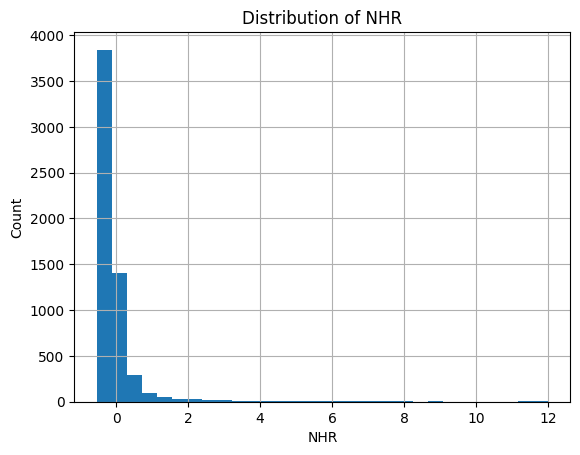

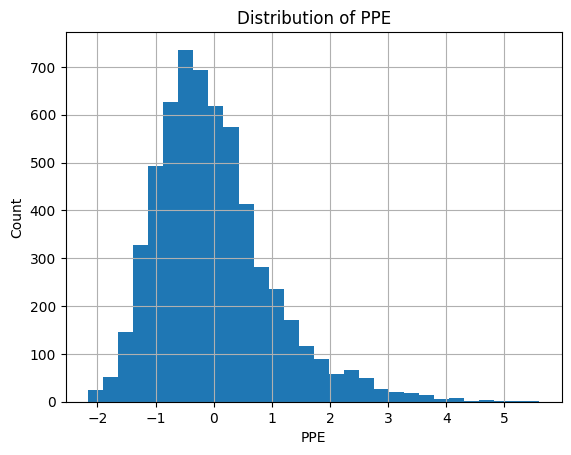

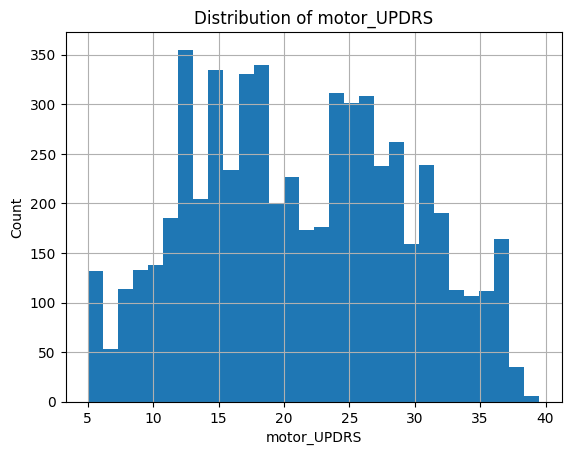

In [ ]:

sample_features = [
    "age",
    "test_time",
    "Jitter(%)",
    "Shimmer:APQ11",
    "NHR",
    "PPE",
]

cols_to_plot = sample_features + ["motor_UPDRS"]

# histograms
for col in cols_to_plot:
    if pd.api.types.is_numeric_dtype(parkinsons_data[col]):
        plt.figure()
        parkinsons_data[col].hist(bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

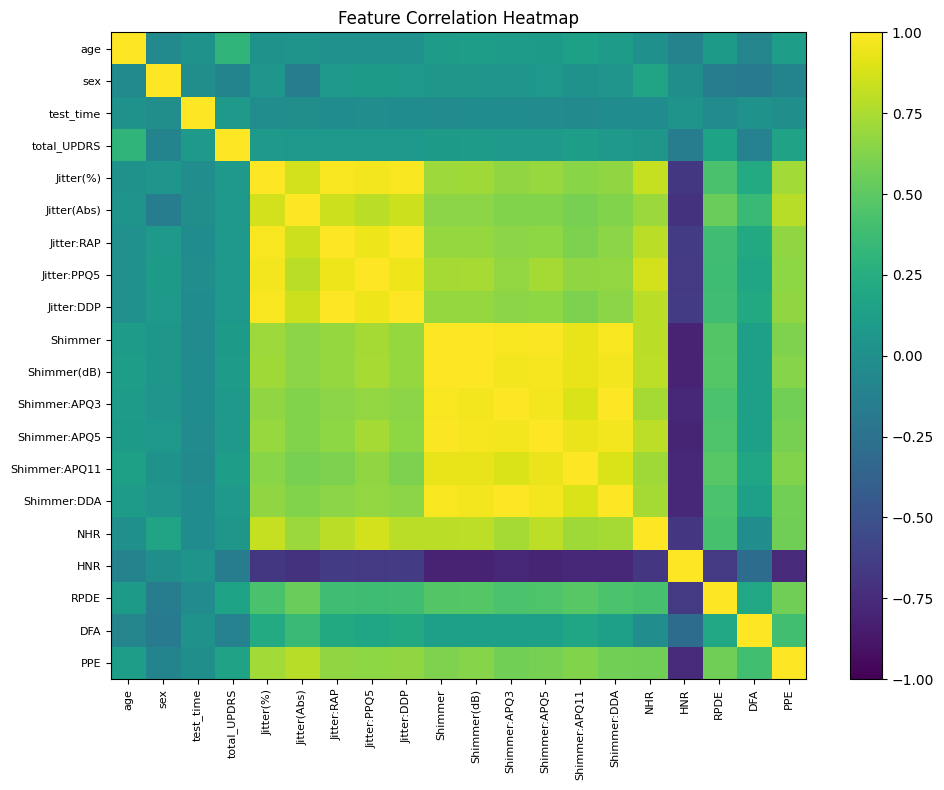

In [ ]:
# Correlation heatmap
parkinsons_target = 'motor_UPDRS'
parkinsons_feature = [x for x in parkinsons_data.columns if x != parkinsons_target]
corr = parkinsons_data[parkinsons_feature].corr()
plt.figure(figsize=(10, 8))
im = plt.imshow(corr.values, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Heatmap')
n = len(parkinsons_feature)
k = max(1, n // 20)
ax = plt.gca()
ax.set_xticks(range(0, n, k))
ax.set_xticklabels([parkinsons_feature[i] for i in range(0, n, k)], rotation=90, fontsize=8)
ax.set_yticks(range(0, n, k))
ax.set_yticklabels([parkinsons_feature[i] for i in range(0, n, k)], fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Most Correlated Features with the target:
top_corr= (
    parkinsons_data[parkinsons_feature + [parkinsons_target]]
    .corr()[parkinsons_target]
    .drop(parkinsons_target)
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
top_corr.head(15)

,motor_UPDRS
total_UPDRS,0.947231
age,0.273665
PPE,0.162433
HNR,-0.157029
Shimmer:APQ11,0.136560
RPDE,0.128607
DFA,-0.116242
Shimmer(dB),0.110076
Shimmer,0.102349
Shimmer:APQ5,0.092105


**Wdbc:**

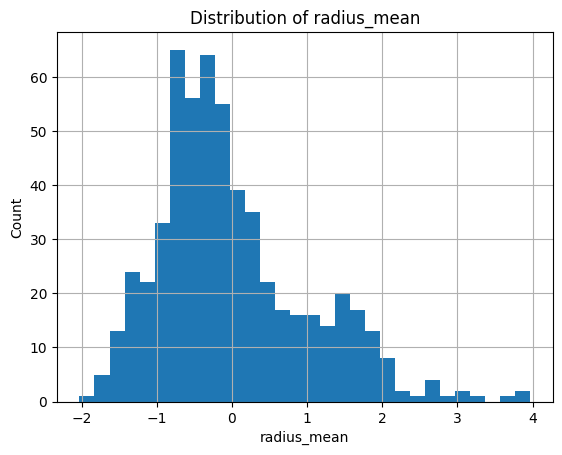

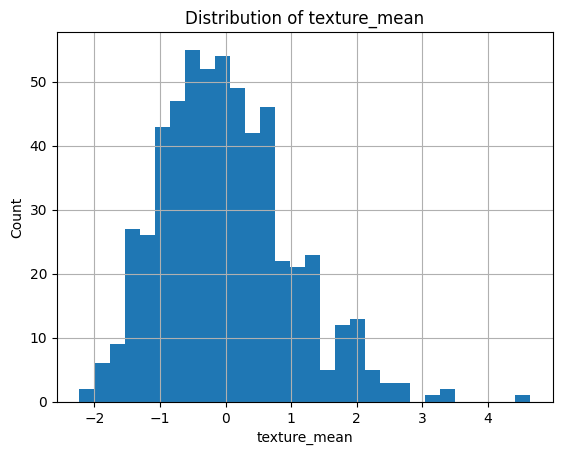

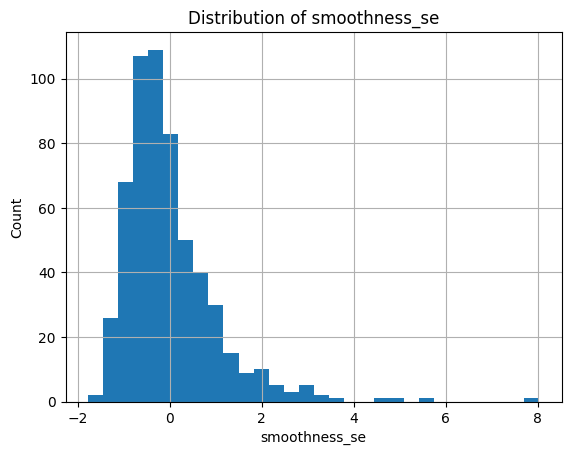

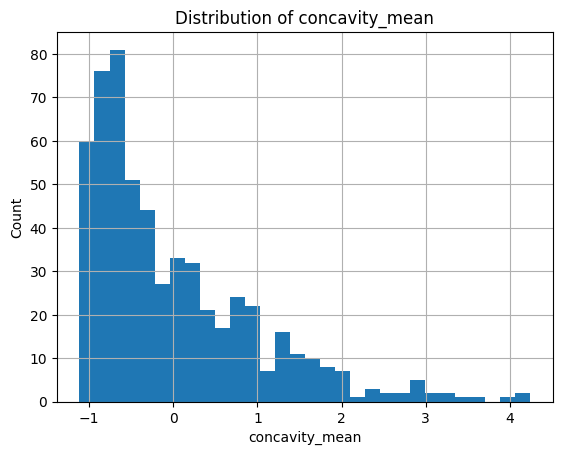

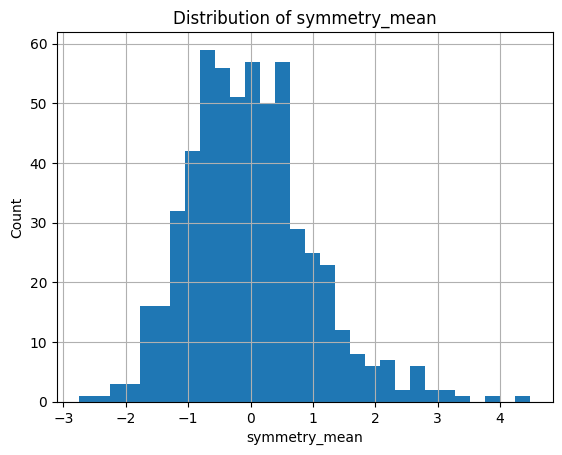

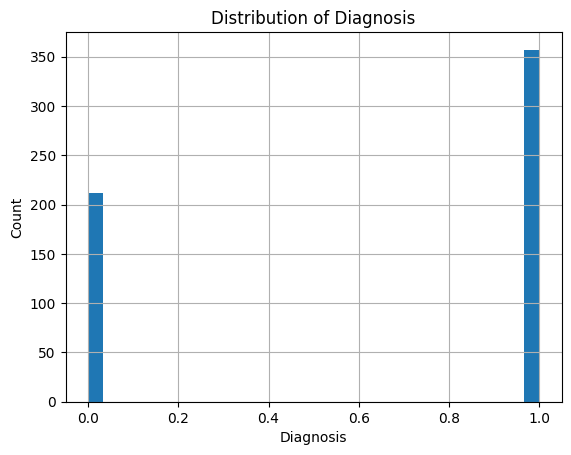

In [ ]:

sample_features = [
    "radius_mean",
    "texture_mean",
    "smoothness_se",
    "concavity_mean",
    "symmetry_mean",
]

cols_to_plot = sample_features + ['Diagnosis']

# histograms
for col in cols_to_plot:
    if pd.api.types.is_numeric_dtype(wdbc_data[col]):
        plt.figure()
        wdbc_data[col].hist(bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

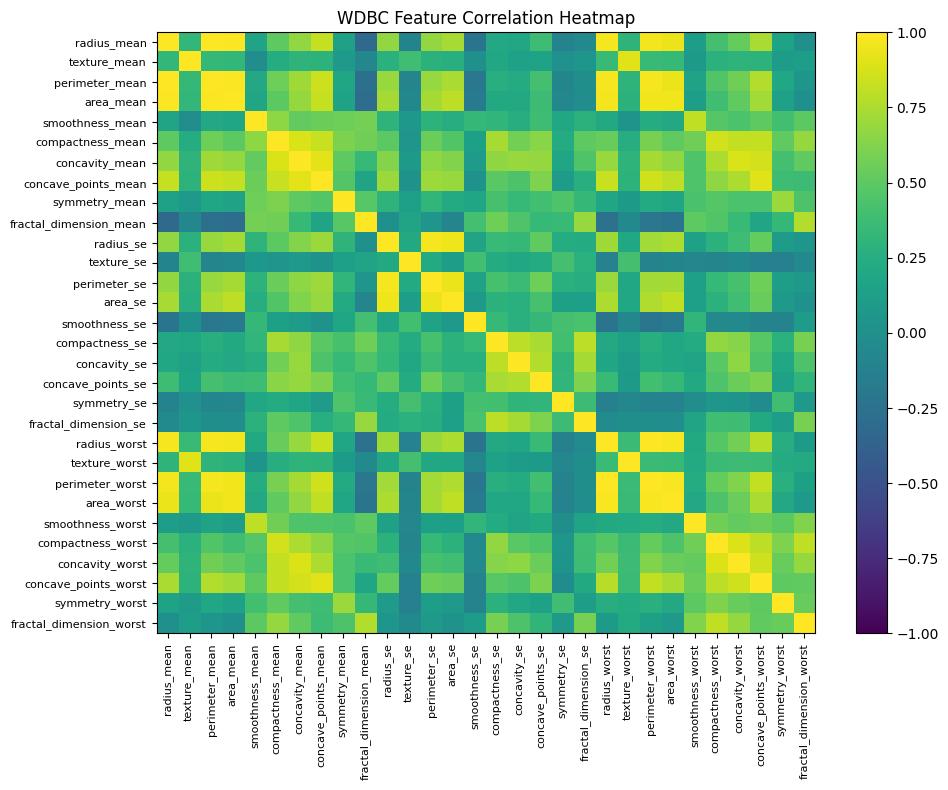

In [ ]:
wdbc_feature = [col for col in wdbc_data.columns if col != "Diagnosis"]
corr = wdbc_data[wdbc_feature].corr()
plt.figure(figsize=(10, 8))
im = plt.imshow(corr.values, aspect='auto', interpolation='nearest', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('WDBC Feature Correlation Heatmap')
n = len(wdbc_feature)
k = max(1, n // 20)
ax = plt.gca()
ax.set_xticks(range(0, n, k))
ax.set_xticklabels([wdbc_feature[i] for i in range(0, n, k)], rotation=90, fontsize=8)
ax.set_yticks(range(0, n, k))
ax.set_yticklabels([wdbc_feature[i] for i in range(0, n, k)], fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Most Correlated Features with the target:
wdbc_target = "Diagnosis"
top_corr = (
    wdbc_data[wdbc_feature + [wdbc_target]]
    .corr()[wdbc_target]
    .drop(wdbc_target)
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
top_corr.head(15)

,Diagnosis
concave_points_worst,-0.793566
perimeter_worst,-0.782914
concave_points_mean,-0.776614
radius_worst,-0.776454
perimeter_mean,-0.742636
area_worst,-0.733825
radius_mean,-0.730029
area_mean,-0.708984
concavity_mean,-0.696360
concavity_worst,-0.659610


## Task 2: Implement the models



**1. Implement analytical linear regression solution for Dataset 1.**

In [ ]:
class LinearRegression:
  def __init__(self, add_bias: bool = True):
        self.add_bias = add_bias
        pass

  def fit(self, x, y):
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if self.add_bias:
        x = np.column_stack([x, np.ones(x.shape[0])])
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    self.w = np.linalg.lstsq(x, y, rcond=None)[0]
    return self

  def predict(self, x):
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if self.add_bias:
        x = np.column_stack([x, np.ones(x.shape[0])])
    return (x @ self.w).ravel()


**2. Implement logistic regression with gradient descent for Dataset 2.**

In [ ]:
logistic = lambda z : 1 / (1 + np.exp(-z))

# cost function
def cost_fn(x, y, w):
    N, D = x.shape
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1 - y) * np.log1p(np.exp(z)))
    return J

# gradient of the cost
def gradient(self, x, y):
    N, D = x.shape
    yh = logistic(np.dot(x, self.w))
    grad = np.dot(x.T, yh - y) / N
    return grad

# logistic regression class
class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iters=int(1e5), verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        self.w = None

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1
        if self.verbose:
            print(f"terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}")
            print(f"the weight found: {self.w}")
        return self

    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))
        return yh

LogisticRegression.gradient = gradient


**3.1. Implement mini-batch stochastic gradient descent for linear regression.**

In [ ]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=10000, epsilon=1e-8,
                 record_history=False, batch_size = None, shuffle=True):
        self.learning_rate  = learning_rate
        self.max_iters      = int(max_iters)
        self.record_history = record_history
        self.epsilon        = epsilon
        self.batch_size     = batch_size
        self.shuffle        = shuffle
        if record_history:
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        N = x.shape[0]
        B = self.batch_size if self.batch_size is not None else N
        B = min(B, N)
        # Full batch
        if B == N:
            grad = np.inf
            t = 1
            while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
                grad = gradient_fn(x, y, w)
                w = w - self.learning_rate * grad
                if self.record_history:
                    self.w_history.append(w.copy())
                t += 1
            return w
        # Mini Batch
        for _ in range(self.max_iters):
            idx = np.arange(N)
            if self.shuffle:
                np.random.shuffle(idx)
            # iterate mini-batches
            for start in range(0, N, B):
                batch = idx[start:start+B]
                xb, yb = x[batch], y[batch]

                grad = gradient_fn(xb, yb, w)
                if np.linalg.norm(grad) <= self.epsilon:
                    return w
                w = w - self.learning_rate * grad
                if self.record_history:
                    self.w_history.append(w.copy())
        return w


class LinearRegressionMiniBatch:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y, optimizer):
        x = np.asarray(x, float)
        y = np.asarray(y, float).ravel()

        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])

        N, D = x.shape

        def gradient(x, y, w):
            yh = x @ w
            N, D = x.shape
            grad = .5 * np.dot(yh - y, x) / N
            return grad

        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self

    def predict(self, x):
        x = np.asarray(x, float)
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        yh = x @ self.w
        return yh

**3.2. Implement mini-batch stochastic gradient descent for logistic regression.**

In [ ]:
logistic = lambda z: 1 / (1 + np.exp(-z))

# cost function
def cost_fn(x, y, w):
    N, D = x.shape
    z = np.dot(x, w)
    J = np.mean(y * np.log1p(np.exp(-z)) + (1 - y) * np.log1p(np.exp(z)))
    return J

# gradient of the cost
def gradient(self, x, y):
    y = np.asarray(y).ravel()
    yh = logistic(np.dot(x, self.w))
    grad = np.dot(x.T, yh - y) / x.shape[0]
    return grad


class LogisticRegressionMiniBatch:
    def __init__(self, add_bias=True, learning_rate=1.0, epsilon=1e-4, max_iters=int(1e5),
                 verbose=False, batch_size=None, shuffle=True):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = int(max_iters)
        self.verbose = verbose
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.w = None

    def fit(self, x, y):
        x = np.asarray(x, float)
        y = np.asarray(y, float).ravel()

        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])

        N, D = x.shape
        self.w = np.zeros(D)

        B = self.batch_size if self.batch_size is not None else N
        B = min(B, N)
        # Mini Batch
        for iter in range(self.max_iters):
            idx = np.arange(N)
            if self.shuffle:
                np.random.shuffle(idx)

            for start in range(0, N, B):
                batch = idx[start:start + B]
                xb, yb = x[batch], y[batch]
                g = self.gradient(xb, yb)
                if np.linalg.norm(g) <= self.epsilon:
                    if self.verbose:
                        print(f"stopped early at iter {iter}, ||grad||={np.linalg.norm(g):.3e}")
                    return self
                self.w = self.w - self.learning_rate * g

        if self.verbose:
            print(f"finished {self.max_iters} iters (batch_size={B})")
        return self

    def predict(self, x):
        x = np.asarray(x, float)
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            x = np.column_stack([x, np.ones(x.shape[0])])
        return logistic(np.dot(x, self.w)).ravel()

LogisticRegressionMiniBatch.gradient = gradient


## Task 3: Run experiments

The goal of this project is to have you be familiar with how to train models.

Split each dataset into training, and test sets. Use test set to estimate performance in all of the experiments after training the model with training set. Evaluate the performance using the corresponding cost function for the classification and regression tasks. **You are welcome to perform any experiments and analyses you see fit, but at a minimum you
must complete the following experiments in the order stated below:**

In [ ]:
# Fit Linear Regression Model
def mse(y, yhat):
    y = np.asarray(y).ravel()
    yhat = np.asarray(yhat).ravel()
    return ((y - yhat)**2).mean()

def r2(y, yhat):
    y = np.asarray(y).ravel()
    yhat = np.asarray(yhat).ravel()
    ss_res = ((y - yhat)**2).sum()
    ss_tot = ((y - y.mean())**2).sum()
    return 1 - ss_res/ss_tot if ss_tot > 0 else 0.0

x = parkinsons_data[parkinsons_feature].to_numpy(float)
y = parkinsons_data[parkinsons_target].to_numpy(float)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
lr = LinearRegression(add_bias=True)
lr.fit(x_train, y_train)
y_hat_train = lr.predict(x_train)
y_hat_test = lr.predict(x_test)

In [ ]:
# Fit Logistic Regression Model
a = wdbc_data[wdbc_feature].to_numpy(float)
b = wdbc_data[wdbc_target].to_numpy(float)

x_tr, x_te, y_tr, y_te = train_test_split(a, b, test_size = 0.2, random_state=1)
logr = LogisticRegression(add_bias=True, learning_rate=1e-2, epsilon=1e-4, max_iters=int(1e5), verbose=False)
logr.fit(x_tr, y_tr)

p_tr = logr.predict(x_tr)
p_te = logr.predict(x_te)


In [ ]:
# Linear Regression Performance
print("Train MSE:", mse(y_train, y_hat_train))
print("Test  MSE:", mse(y_test,  y_hat_test))
print("Test   R²:", r2(y_test, y_hat_test))


Train MSE: 6.216528775298067
Test  MSE: 6.401105857045869
Test   R²: 0.9077151062467492


In [ ]:
# Logistic Regression Performance
def cross_entropy(y, p):
    y = np.asarray(y).ravel().astype(float)
    p = np.asarray(p).ravel().astype(float)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    ce = -y*np.log(p) - (1 - y)*np.log(1 - p)
    return float(ce.mean())

train_ce = cross_entropy(y_tr, p_tr)
test_ce  = cross_entropy(y_te, p_te)

print("Train cross-entropy:", train_ce)
print("Test  cross-entropy:", test_ce)


Train cross-entropy: 0.04305049732842453
Test  cross-entropy: 0.08500481390873214


In [ ]:
# Linear Regression Weights
w = lr.w.ravel()
weights_df = pd.DataFrame({
    "feature": parkinsons_feature + ["(intercept)"],
    "weight":  np.r_[w[:-1], w[-1]]
})
weights_df["|weight|"] = weights_df["weight"].abs()
weights_df = weights_df.sort_values("|weight|", ascending=False)
display(weights_df)

,feature,weight,|weight|
14,Shimmer:DDA,-99.276263,99.276263
11,Shimmer:APQ3,99.206789,99.206789
20,(intercept),21.272715,21.272715
6,Jitter:RAP,-7.908905,7.908905
3,total_UPDRS,7.742734,7.742734
8,Jitter:DDP,7.298099,7.298099
12,Shimmer:APQ5,-1.697885,1.697885
4,Jitter(%),1.198718,1.198718
9,Shimmer,1.026141,1.026141
13,Shimmer:APQ11,0.866946,0.866946


Shimmer:DDA (−99.28) and Shimmer:APQ3 (+99.21) are the dominant features. Their weights are way larger than the other features.

In [ ]:
# Logistic Regression Weights
w = np.asarray(logr.w)
weights_df = pd.DataFrame({
    "feature": list(wdbc_feature) + ["(intercept)"],
    "weight":  np.r_[w[:-1], w[-1]]
})
weights_df["abs_weight"] = weights_df["weight"].abs()
weights_df = weights_df.sort_values("abs_weight", ascending=False)
display(weights_df)

,feature,weight,abs_weight
10,radius_se,-2.119457,2.119457
20,radius_worst,-1.707970,1.707970
23,area_worst,-1.660089,1.660089
21,texture_worst,-1.623292,1.623292
15,compactness_se,1.566083,1.566083
13,area_se,-1.511007,1.511007
26,concavity_worst,-1.498952,1.498952
22,perimeter_worst,-1.429999,1.429999
7,concave_points_mean,-1.314876,1.314876
19,fractal_dimension_se,1.297709,1.297709


The top four features with geatest weights all have negative coefficient.
The top three features are radius_se (−2.12), radius_worst (−1.71), area_worst (−1.66), which are all about tumor size.

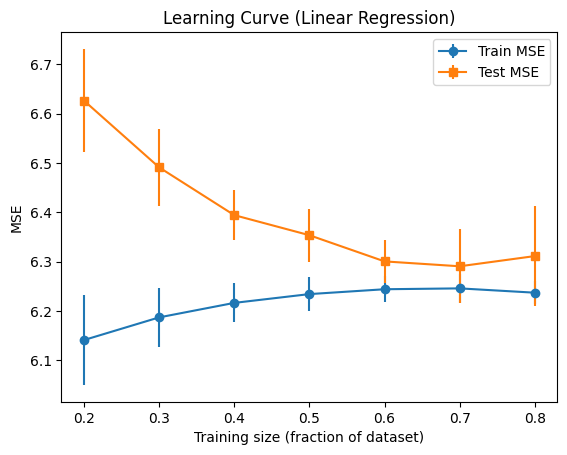

,train_size,train_MSE_mean,train_MSE_CI95,test_MSE_mean,test_MSE_CI95,runs
0,0.2,6.140856,0.090976,6.626361,0.104796,30
1,0.3,6.186804,0.059894,6.491041,0.077531,30
2,0.4,6.216218,0.039643,6.394132,0.051057,30
3,0.5,6.234034,0.034456,6.353417,0.053703,30
4,0.6,6.243882,0.026667,6.300330,0.043328,30
5,0.7,6.245624,0.029619,6.290438,0.075409,30
6,0.8,6.236882,0.023513,6.311132,0.101953,30


In [ ]:
# Linear Regression Result for different training data size
def mean_ci(a):
            m = a.mean()
            se = a.std(ddof=1) / np.sqrt(len(a))
            ci = 1.96 * se
            return m, ci

def learning_curve_mse(
    X, y,
    train_sizes = np.arange(0.2, 0.9, 0.1),
    runs = 50,
    base_seed = 4
):
    results = []
    for s in train_sizes:
        train_mses, test_mses = [], []
        for r in range(runs):
            rs = base_seed + r
            Xtr, Xte, ytr, yte = train_test_split(X, y, train_size=s, test_size=1.0-s, random_state=rs)
            scaler = StandardScaler().fit(Xtr)
            Xtr = scaler.transform(Xtr)
            Xte = scaler.transform(Xte)
            lr = LinearRegression(add_bias=True).fit(Xtr, ytr)
            yhat_tr = lr.predict(Xtr)
            yhat_te = lr.predict(Xte)
            train_mses.append(mse(ytr, yhat_tr))
            test_mses.append(mse(yte, yhat_te))

        train_mses = np.array(train_mses)
        test_mses  = np.array(test_mses)
        tr_mean, tr_ci = mean_ci(train_mses)
        te_mean, te_ci = mean_ci(test_mses)

        results.append({
            "train_size": s,
            "train_MSE_mean": tr_mean, "train_MSE_CI95": tr_ci,
            "test_MSE_mean":  te_mean, "test_MSE_CI95":  te_ci,
            "runs": runs
        })

    summary = pd.DataFrame(results)

    fig, ax = plt.subplots()
    ax.errorbar(summary["train_size"], summary["train_MSE_mean"],
                yerr=summary["train_MSE_CI95"], marker="o", linestyle="-", label="Train MSE")
    ax.errorbar(summary["train_size"], summary["test_MSE_mean"],
                yerr=summary["test_MSE_CI95"], marker="s", linestyle="-", label="Test MSE")
    ax.set_xlabel("Training size (fraction of dataset)")
    ax.set_ylabel("MSE")
    ax.set_title("Learning Curve (Linear Regression)")
    ax.legend()
    plt.show()

    return summary

summary_df = learning_curve_mse(x, y, train_sizes=np.arange(0.2, 0.9, 0.1), runs=30)
summary_df


When training data size increases, the test error gets lower, gap becomes smaller. The best result is when train_size = 0.7.

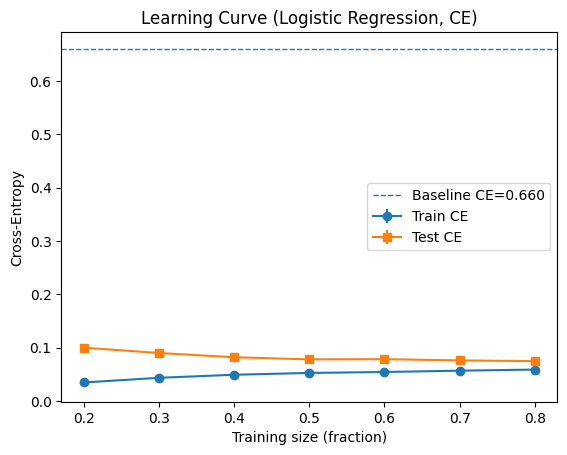

,train_size,train_CE_mean,train_CE_CI95,test_CE_mean,test_CE_CI95,runs
0,0.2,0.034981,0.004606,0.100146,0.004924,50
1,0.3,0.043721,0.004575,0.090213,0.004326,50
2,0.4,0.049445,0.004569,0.082291,0.004621,50
3,0.5,0.052829,0.003368,0.078280,0.004410,50
4,0.6,0.054599,0.003303,0.078652,0.006047,50
5,0.7,0.057084,0.002447,0.076310,0.006746,50
6,0.8,0.059154,0.001856,0.074986,0.008149,50


In [ ]:
# Logistic Regression Result for different training data size
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def learning_curve_ce(
    X, y, train_sizes=np.arange(0.2, 0.9, 0.1),
    runs=30, base_seed=42, stratify=True
):
    rows = []

    for s in train_sizes:
        tr_losses, te_losses = [], []
        for r in range(runs):
            rs = base_seed + r
            Xtr, Xte, ytr, yte = train_test_split(
                X, y, train_size=s, test_size=1-s,
                random_state=rs, stratify=y if stratify else None
            )
            scaler = StandardScaler().fit(Xtr)
            Xtr = scaler.transform(Xtr)
            Xte = scaler.transform(Xte)
            m = LogisticRegression(
                add_bias=True, learning_rate=1e-2, epsilon=1e-4,
                max_iters=int(10000), verbose=False
                )
            m.fit(Xtr, ytr)
            p_tr = m.predict(Xtr)
            p_te = m.predict(Xte)
            tr_losses.append(cross_entropy(ytr, p_tr))
            te_losses.append(cross_entropy(yte, p_te))

        tr = np.array(tr_losses); te = np.array(te_losses)
        rows.append({
            "train_size": s,
            "train_CE_mean": tr.mean(),
            "train_CE_CI95": 1.96 * tr.std(ddof=1) / np.sqrt(runs),
            "test_CE_mean":  te.mean(),
            "test_CE_CI95":  1.96 * te.std(ddof=1) / np.sqrt(runs),
            "runs": runs
        })

    summary = pd.DataFrame(rows)

    baseline = cross_entropy(y, np.full_like(y, y.mean(), dtype=float))

    title = "Learning Curve (Logistic Regression, CE)"
    plt.figure()
    plt.errorbar(summary["train_size"], summary["train_CE_mean"],
                 yerr=summary["train_CE_CI95"], marker="o", label="Train CE")
    plt.errorbar(summary["train_size"], summary["test_CE_mean"],
                 yerr=summary["test_CE_CI95"], marker="s", label="Test CE")
    plt.axhline(baseline, linestyle="--", linewidth=1, label=f"Baseline CE={baseline:.3f}")
    plt.xlabel("Training size (fraction)")
    plt.ylabel("Cross-Entropy")
    plt.title(title)
    plt.legend()
    plt.show()

    return summary

summary_ce = learning_curve_ce(
    a, b,
    train_sizes=np.arange(0.2, 0.9, 0.1),
    runs=50, base_seed=7
)
summary_ce


Same as what we have for linear regression, increasing training size makes test loss lower, gap smaller. The best result is observed when train_size = 0.8.

In [ ]:
# Linear Regression Mini-Batch Analysis
import time, math
batch_size = [None, 8, 16, 32, 64, 128, 256, 512]

def batch_linear(X, y, test_size = 0.2,seed = 8):

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)

    rows = []
    n_train = Xtr.shape[0]

    for bs in batch_size:
        opt = GradientDescent(
            learning_rate = 0.01,
            max_iters = 1000,
            batch_size = bs,
        )

        model = LinearRegressionMiniBatch(add_bias= True)
        t0 = time.perf_counter()
        model.fit(Xtr, ytr, optimizer=opt)
        elapsed = time.perf_counter() - t0

        yhat_tr = model.predict(Xtr)
        yhat_te = model.predict(Xte)
        tr_mse = mse(ytr, yhat_tr)
        te_mse = mse(yte, yhat_te)

        rows.append({
            "batch_size": "full" if bs is None else bs,
            "time_sec": elapsed,
            "train_MSE": tr_mse,
            "test_MSE": te_mse
        })

    return pd.DataFrame(rows)


X = parkinsons_data[parkinsons_feature].to_numpy(float)
y = parkinsons_data[parkinsons_target].to_numpy(float)
lin_summary = batch_linear(X, y)
print(lin_summary)


  batch_size   time_sec  train_MSE  test_MSE
0       full   0.109180   6.397357  6.280219
1          8  10.831162   6.283186  6.153435
2         16   6.149910   6.276537  6.150675
3         32   2.697230   6.277985  6.172984
4         64   1.619008   6.274314  6.148573
5        128   0.940214   6.275737  6.155446
6        256   0.926324   6.280169  6.165725
7        512   0.818764   6.288619  6.172914


As batch size increase, the time need becomes less while the performance is not affected strongly. Best result (lowest test_MSE, 6.140936) is when batch_size = 16.

In [ ]:
# Logistic Regression Mini-Batch Analysis

batch_size = [None, 8, 16, 32, 64, 128, 256, 512]

def batch_logistic(X, y, test_size = 0.2,seed = 8):

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed)

    rows = []
    n_train = Xtr.shape[0]

    for bs in batch_size:
        if bs is None:
            m = LogisticRegression(add_bias=True, learning_rate=0.01, max_iters=1000, verbose=False)
        else:
            m = LogisticRegressionMiniBatch(add_bias=True, learning_rate=0.01, max_iters=10000, verbose=False,
                                             batch_size=bs)
        t0 = time.perf_counter()
        m.fit(Xtr, ytr)
        elapsed = time.perf_counter() - t0

        yhat_tr = m.predict(Xtr)
        yhat_te = m.predict(Xte)
        p_tr = m.predict(Xtr)
        p_te = m.predict(Xte)

        rows.append({
            "batch_size": "full" if bs is None else bs,
            "time_sec": elapsed,
            "train_CE": cross_entropy(ytr, p_tr),
            "test_CE":  cross_entropy(yte, p_te)
        })

    return pd.DataFrame(rows)


a = wdbc_data[wdbc_feature].to_numpy(float)
b = wdbc_data[wdbc_target].to_numpy(float)
lin_summary = batch_logistic(a, b)
print(lin_summary)


  batch_size  time_sec  train_CE   test_CE
0       full  0.050420  0.107822  0.087184
1          8  0.494702  0.061449  0.044043
2         16  1.021868  0.057043  0.039344
3         32  0.858886  0.058730  0.041385
4         64  0.406998  0.062435  0.044857
5        128  1.163496  0.055336  0.037215
6        256  0.806082  0.059364  0.041851
7        512  0.604535  0.065033  0.047319


As batch size increase to 64, the time need varies, while the performance is not affected strongly. Best result (lowest test_CE, 0.037217
) is when batch_size = 128.

In [ ]:
# Linear Regression With Different Learning Rates:
rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for rate in rates:
    optimizer = GradientDescent(learning_rate=rate, max_iters=100000, batch_size = None)
    lr = LinearRegressionMiniBatch(add_bias=True)
    lr.fit(x_train, y_train, optimizer)
    y_hat_train = lr.predict(x_train)
    y_hat_test = lr.predict(x_test)
    print(f"  LR={rate:>6}: Train MSE={mse(y_train, y_hat_train):.6f} | Test MSE={mse(y_test, y_hat_test):.6f} | Test R²={r2(y_test, y_hat_test):.6f}")

  LR= 1e-05: Train MSE=193.493831 | Test MSE=200.162883 | Test R²=-1.885753
  LR=0.0001: Train MSE=6.372241 | Test MSE=6.489349 | Test R²=0.906443
  LR= 0.001: Train MSE=6.234540 | Test MSE=6.387078 | Test R²=0.907917
  LR=  0.01: Train MSE=6.217038 | Test MSE=6.404498 | Test R²=0.907666
  LR=   0.1: Train MSE=6.216981 | Test MSE=6.403663 | Test R²=0.907678


In [ ]:
# Logistic Regression With Different Learning Rates:
rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for rate in rates:
  logr = LogisticRegression(add_bias=True, learning_rate=rate, epsilon=1e-4, max_iters=int(1e5), verbose=False)
  logr.fit(x_tr, y_tr)
  p_tr = logr.predict(x_tr)
  p_te = logr.predict(x_te)
  train_ce = cross_entropy(y_tr, p_tr)
  test_ce  = cross_entropy(y_te, p_te)
  print(f"  LR={rate:>6}: Train Cross-Entropy={train_ce} | Test Cross-Entropy={test_ce}")

  LR= 1e-05: Train Cross-Entropy=0.24167995183751123 | Test Cross-Entropy=0.27921592515368854
  LR=0.0001: Train Cross-Entropy=0.1004141569599728 | Test Cross-Entropy=0.12197501438185598
  LR= 0.001: Train Cross-Entropy=0.059321451839648084 | Test Cross-Entropy=0.07433281034747899
  LR=  0.01: Train Cross-Entropy=0.04305049732842453 | Test Cross-Entropy=0.08500481390873214
  LR=   0.1: Train Cross-Entropy=0.030534609452947066 | Test Cross-Entropy=0.18898972164661143


 - The linear regression method provides a more direct and  efficient solution for smaller datasets, yielding an exact minimum for the training data's loss function, resulting in a test MSE of 6.280 in our experiment.
 - The mini-batch stochastic gradient descent offers an iterative approximation that achieved a test MSE of 6.141, which improved performance on unseen data.
 - The analytical approach is precise and fast for datasets that fit in memory, mini-batch SGD is far more scalable for large-scale applications and can often produce a more robust model.

Adding regularization:

In [ ]:
#add Regularization to LinearRegression
class LinearRegression:
  def __init__(self, add_bias: bool = True, l2_reg=0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        pass

  def fit(self, x, y):
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if self.add_bias:
        x = np.column_stack([x, np.ones(x.shape[0])])
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    N,D = x.shape
    reg_matrix = self.l2_reg * np.eye(D)
    if self.add_bias:
        reg_matrix[-1, -1] = 0
    self.w = np.linalg.inv(x.T @ x + reg_matrix) @ (x.T @ y)
    return self

  def predict(self, x):
    x = np.asarray(x, dtype=float)
    if x.ndim == 1:
        x = x[:, None]
    if self.add_bias:
        x = np.column_stack([x, np.ones(x.shape[0])])
    return (x @ self.w).ravel()



In [ ]:
# Fit new Linear Regression Model
def mse(y, yhat):
    y = np.asarray(y).ravel()
    yhat = np.asarray(yhat).ravel()
    return ((y - yhat)**2).mean()

def r2(y, yhat):
    y = np.asarray(y).ravel()
    yhat = np.asarray(yhat).ravel()
    ss_res = ((y - yhat)**2).sum()
    ss_tot = ((y - y.mean())**2).sum()
    return 1 - ss_res/ss_tot if ss_tot > 0 else 0.0

x = parkinsons_data[parkinsons_feature].to_numpy(float)
y = parkinsons_data[parkinsons_target].to_numpy(float)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
reg_list = [0, 1, 10]
for reg in reg_list:
    lr = LinearRegression(add_bias=True, l2_reg=reg)
    lr.fit(x_train, y_train)
    y_hat_train = lr.predict(x_train)
    y_hat_test = lr.predict(x_test)
    print("Train MSE:", mse(y_train, y_hat_train))
    print("Test  MSE:", mse(y_test,  y_hat_test))
    print("Test   R²:", r2(y_test, y_hat_test))

Train MSE: 6.216528775298068
Test  MSE: 6.401105856097791
Test   R²: 0.9077151062604176
Train MSE: 6.2170100017407135
Test  MSE: 6.40283276503451
Test   R²: 0.9076902093736443
Train MSE: 6.218998907281084
Test  MSE: 6.39706907866094
Test   R²: 0.9077733045757064


- Training error rises slightly with stronger regularization.

- Test error rises slightly when λ=1 but decreases when λ=10.

- R² are very similar, predictive power is basically the same.

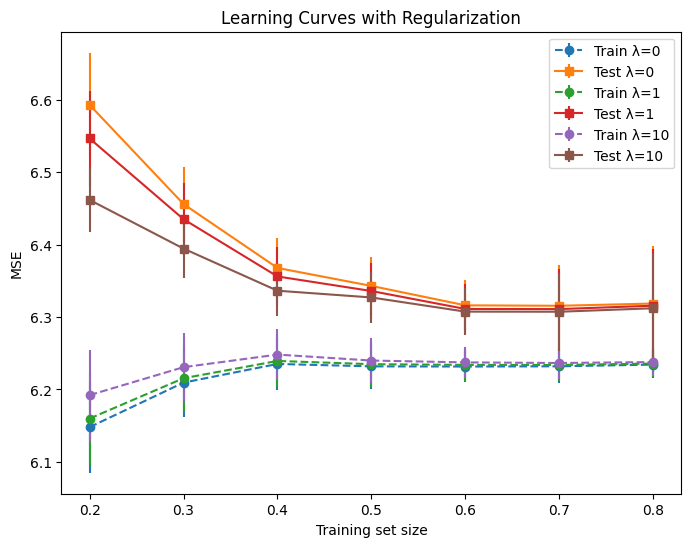

In [ ]:
# Learning curves with Regularization
def learning_curve_mse_reg(
    X, y,
    reg_list = [0, 1, 10],
    train_sizes = np.arange(0.2, 0.9, 0.1),
    runs = 50,
    base_seed = 4
):
    results = []
    for reg in reg_list:
        for s in train_sizes:
            train_mses, test_mses = [], []
            for r in range(runs):
                rs = base_seed + r
                Xtr, Xte, ytr, yte = train_test_split(
                    X, y,
                    train_size=s, test_size=1.0-s,
                    random_state=rs
                )
                scaler = StandardScaler().fit(Xtr)
                Xtr = scaler.transform(Xtr)
                Xte = scaler.transform(Xte)
                lr = LinearRegression(add_bias=True, l2_reg=reg)
                lr.fit(Xtr, ytr)
                yhat_tr = lr.predict(Xtr)
                yhat_te = lr.predict(Xte)
                train_mses.append(mse(ytr, yhat_tr))
                test_mses.append(mse(yte, yhat_te))
            m_tr, ci_tr = mean_ci(np.array(train_mses))
            m_te, ci_te = mean_ci(np.array(test_mses))
            results.append((reg, s, m_tr, ci_tr, m_te, ci_te))
    return pd.DataFrame(results, columns=["λ", "train_size", "train_mse", "train_ci", "test_mse", "test_ci"])

df_results = learning_curve_mse_reg(x, y)
fig, ax = plt.subplots(figsize=(8,6))
for reg, group in df_results.groupby("λ"):
    ax.errorbar(group["train_size"], group["train_mse"], yerr=group["train_ci"],
                label=f"Train λ={reg}", linestyle="--", marker="o")
    ax.errorbar(group["train_size"], group["test_mse"], yerr=group["test_ci"],
                label=f"Test λ={reg}", linestyle="-", marker="s")
ax.set_xlabel("Training set size")
ax.set_ylabel("MSE")
ax.set_title("Learning Curves with Regularization")
ax.legend()
plt.show()


In [ ]:
df_results.groupby("λ")[["train_mse","test_mse"]].mean()


,train_mse,test_mse
λ,,
0,6.217473,6.387149
1,6.221851,6.373054
10,6.231805,6.349500


- With different λ, all the training and testing MSE are similar. We can conclude that our model does not overfitting strongly.
- The best result is when λ=10, the mean test MSE is the lowest.
- As λ increases, training MSE increase slightly and testing MSE decrease slightly, which means that regularization contribute to improve our model a little.
- Since the origin Linear Regression model generalizes well already, it is not neccessary to add regulation in batch analysis.

In [ ]:
#add Regularization to LogisticRegression

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iters=int(1e5), verbose=False, l2_reg=0):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.verbose = verbose
        self.l2_reg = l2_reg
        self.w = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        if self.add_bias:
            X = np.c_[np.ones(X.shape[0]), X]
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        prev_loss = np.inf
        for i in range(self.max_iters):
            y_hat = self._sigmoid(X.dot(self.w))
            grad = (X.T.dot(y_hat - y)) / n_samples
            grad += self.l2_reg * self.w / n_samples
            self.w -= self.learning_rate * grad

            # compute cross-entropy for early stopping
            loss = -np.mean(y*np.log(y_hat+1e-12) + (1-y)*np.log(1-y_hat+1e-12))
            if abs(prev_loss - loss) < self.epsilon:
                break
            prev_loss = loss

    def predict_proba(self, X):
        if self.add_bias:
            X = np.c_[np.ones(X.shape[0]), X]
        return self._sigmoid(X.dot(self.w))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [ ]:
# Fit Logistic Regression Model with Regularization
a = wdbc_data[wdbc_feature].to_numpy(float)
b = wdbc_data[wdbc_target].to_numpy(float)

x_tr, x_te, y_tr, y_te = train_test_split(a, b, test_size=0.2, random_state=1)

reg_list = [0, 1, 10]

for reg in reg_list:
    logr = LogisticRegression(add_bias=True,learning_rate=1,epsilon=1e-4, max_iters=int(1e5), verbose=False,l2_reg=reg)
    logr.fit(x_tr, y_tr)

    p_tr = logr.predict_proba(x_tr)
    p_te = logr.predict_proba(x_te)

    train_ce = cross_entropy(y_tr, p_tr)
    test_ce  = cross_entropy(y_te, p_te)

    print(f"λ={reg}")
    print("  Train cross-entropy:", train_ce)
    print("  Test  cross-entropy:", test_ce)


λ=0
  Train cross-entropy: 0.059302377786659484
  Test  cross-entropy: 0.07392464520502108
λ=1
  Train cross-entropy: 0.0630581647829483
  Test  cross-entropy: 0.0771342529020989
λ=10
  Train cross-entropy: 0.08815021667924784
  Test  cross-entropy: 0.10534553227039113


- Same as the result from linear regression with regularization, the performance of our logistic regression model is not affected strongly by regularization.
- The best result is when there is no regularization. While when λ=10 both training and testing errors are much higher, means that the model is underfitting.

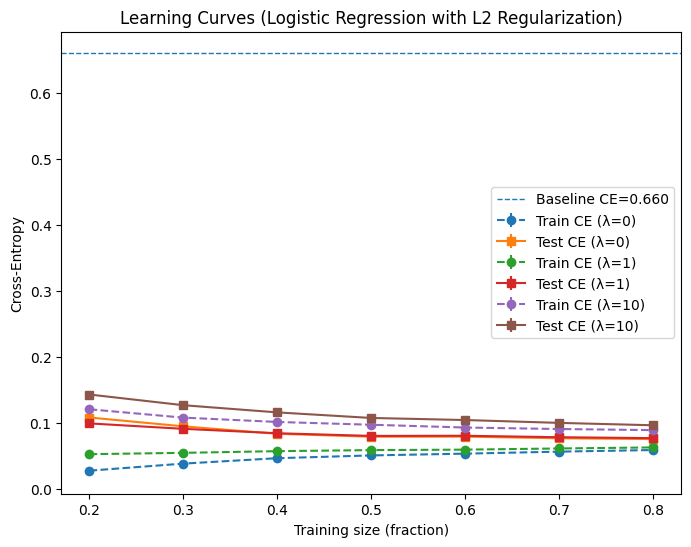

,λ,train_size,train_CE_mean,train_CE_CI95,test_CE_mean,test_CE_CI95,runs
0,0,0.2,0.027461,0.003127,0.107949,0.006275,50
1,0,0.3,0.038136,0.003985,0.094540,0.004631,50
2,0,0.4,0.046343,0.004634,0.083259,0.004807,50
3,0,0.5,0.050537,0.003640,0.078856,0.004673,50
4,0,0.6,0.053225,0.003564,0.078984,0.006217,50
5,0,0.7,0.056254,0.002615,0.076499,0.006851,50
6,0,0.8,0.058719,0.001962,0.075238,0.008199,50
7,1,0.2,0.052429,0.004637,0.099002,0.003879,50
8,1,0.3,0.054449,0.004353,0.090783,0.003689,50
9,1,0.4,0.056991,0.004365,0.084126,0.003953,50


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Logistic Regression Result for different training data size (with regularization)
def learning_curve_ce_reg(
    X, y, reg_list=[0, 1, 10],
    train_sizes=np.arange(0.2, 0.9, 0.1),
    runs=30, base_seed=42, stratify=True
):
    rows = []
    for reg in reg_list:
        for s in train_sizes:
            tr_losses, te_losses = [], []
            for r in range(runs):
                rs = base_seed + r
                Xtr, Xte, ytr, yte = train_test_split(
                    X, y, train_size=s, test_size=1-s,
                    random_state=rs, stratify=y if stratify else None
                )
                scaler = StandardScaler().fit(Xtr)
                Xtr = scaler.transform(Xtr)
                Xte = scaler.transform(Xte)
                m = LogisticRegression(
                    add_bias=True,learning_rate=1,epsilon=1e-4, max_iters=int(1e5), verbose=False,l2_reg=reg
                )
                m.fit(Xtr, ytr)
                p_tr = m.predict_proba(Xtr)
                p_te = m.predict_proba(Xte)
                tr_losses.append(cross_entropy(ytr, p_tr))
                te_losses.append(cross_entropy(yte, p_te))

            tr = np.array(tr_losses); te = np.array(te_losses)
            rows.append({
                "λ": reg,
                "train_size": s,
                "train_CE_mean": tr.mean(),
                "train_CE_CI95": 1.96 * tr.std(ddof=1) / np.sqrt(runs),
                "test_CE_mean":  te.mean(),
                "test_CE_CI95":  1.96 * te.std(ddof=1) / np.sqrt(runs),
                "runs": runs
            })

    summary = pd.DataFrame(rows)

    baseline = cross_entropy(y, np.full_like(y, y.mean(), dtype=float))

    plt.figure(figsize=(8,6))
    for reg, group in summary.groupby("λ"):
        plt.errorbar(group["train_size"], group["train_CE_mean"],
                     yerr=group["train_CE_CI95"], marker="o", linestyle="--",
                     label=f"Train CE (λ={reg})")
        plt.errorbar(group["train_size"], group["test_CE_mean"],
                     yerr=group["test_CE_CI95"], marker="s", linestyle="-",
                     label=f"Test CE (λ={reg})")
    plt.axhline(baseline, linestyle="--", linewidth=1,
                label=f"Baseline CE={baseline:.3f}")
    plt.xlabel("Training size (fraction)")
    plt.ylabel("Cross-Entropy")
    plt.title("Learning Curves (Logistic Regression with L2 Regularization)")
    plt.legend()
    plt.show()
    return summary

summary_ce_reg = learning_curve_ce_reg(
    a, b, reg_list=[0, 1, 10],
    train_sizes=np.arange(0.2, 0.9, 0.1),
    runs=50, base_seed=7
)
summary_ce_reg


- For λ=0 and λ=1, test CE improves as training size increases and stabilizes around 0.075 to 0.078, shows that our model benefits from more data.
- For λ=10, the test CE stays high regardless of training size, regularization prevents the model from learning well.

Hypotheses about how L2 regularization will interact with batch size:

Our models already generalizes well, so batch-size effects on final generalization will likely be small.
After regularization, the main practical impact of batch size will be training speed, not making large difference in performance.